#Name - Alon Malach
#ID - 207024878

## Setup



In [ ]:
#from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
auth.authenticate_user()

In [ ]:
#@title Fill out this form then press [shift ⇧]+[enter ⏎] {run: "auto"}
import subprocess
import re

analysis_project = 'named-griffin-348712'  #@param {type:"string"}

In [ ]:
admissions_table = f'physionet-data.mimic_core.admissions'
d_labitems_table = f'physionet-data.mimic_hosp.d_labitems'
labevents_table = f'physionet-data.mimic_hosp.labevents'
patients_table = f'physionet-data.mimic_core.patients'
d_icd_diagnoses_table = f'physionet-data.mimic_hosp.d_icd_diagnoses'
diagnoses_icd_table = f'physionet-data.mimic_hosp.diagnoses_icd'
icustays_table = f'physionet-data.mimic_icu.icustays'

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'icustays_table':icustays_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'd_labitems_table': d_labitems_table,
    'labevents_table': labevents_table,
    'patients_table': patients_table,
    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
magics.context.project = analysis_project

In [ ]:
# Set up the substitution preprocessing injection
original_run_query = magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  #return original_run_query(client, query, job_config)
  return original_run_query(client, query, job_config)

#bigquery.magics._run_query = format_and_run_query
magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

analysis_project: named-griffin-348712

custom %%bigquery magic substitutions:
  {icustays_table} → physionet-data.mimic_icu.icustays
  {d_icd_diagnoses_table} → physionet-data.mimic_hosp.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimic_hosp.diagnoses_icd
  {analysis_project} → named-griffin-348712
  {admissions_table} → physionet-data.mimic_core.admissions
  {d_labitems_table} → physionet-data.mimic_hosp.d_labitems
  {labevents_table} → physionet-data.mimic_hosp.labevents
  {patients_table} → physionet-data.mimic_core.patients
  {ml_table_prefix} → named-griffin-348712.MIMIC.models_


In [ ]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
bq = bigquery.Client(project=analysis_project)

In [ ]:
def run_query(query):
  project_id = analysis_project
  df = pd.read_gbq(query, project_id=project_id, dialect='standard')
  return df

### Create data set named MIMIC
Make sure you have created a dataset named MIMIC, or create it if you don't have it under your project. 

In [ ]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

## Case complexity & mortality

In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
%%bigquery
SELECT
  COUNT(*) as total,
  SUM(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}`

,total,died
0,523740,9350


We can see the data is inbalance

##First of all - look at the results, and make simple model:
###Note - I limit the labs count to n<=600 because below we have few data points that make the model very sparse and the colab got stuck.

In [ ]:
%%bigquery hist_df_n_labs
SELECT
  n_labs, COUNT(*) AS cnt
FROM (
  SELECT
    COUNT(*) AS n_labs
  FROM
    `{labevents_table}`
  GROUP BY
    HADM_ID
)
GROUP BY n_labs
ORDER BY n_labs
limit 600

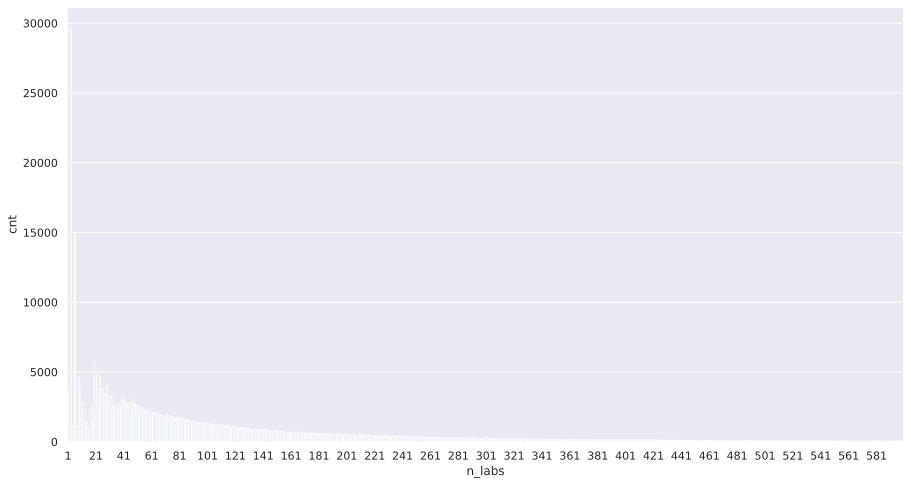

In [ ]:
# hist_df is a dataframe fromp previous cell (variable name defined in first the row)

sns.set(rc={'figure.figsize':(15,8)})

g = sns.barplot(
    x=hist_df_n_labs.n_labs, y=hist_df_n_labs.cnt, color=sns.color_palette()[0])

for i, label in enumerate(g.get_xticklabels()):
  if i % 20 in range(1,20):
    label.set_visible(False)

#1. Predict mortality during admission by number of labs:

### Creating a classification model



In [ ]:
%%bigquery
# BigQuery ML create model statement:
CREATE OR REPLACE MODEL `{ml_table_prefix}labs_mortality_models`

OPTIONS(
  # Use logistic_reg for discrete predictions (classification) and linear_reg
  # for continuous predictions (forecasting).
  model_type = 'logistic_reg',
  # See the below aside (𝜎 = 0.5 ⇒ 𝜆 = 2)
  l2_reg = 2,
  # Identify the column to use as the label (dependent variable)
  input_label_cols = ["died"]
)
AS
# standard SQL query to train the model with:
SELECT
  COUNT(*) AS number_of_labs,
  MAX(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}`
  INNER JOIN `{labevents_table}`
  USING (HADM_ID)
GROUP BY HADM_ID
having number_of_labs<600

### Plotting the predictions

First look at the weights:
[`ML.WEIGHTS`]

In [ ]:
%%bigquery simple_model_weights
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}labs_mortality_models`)

In [ ]:
params = {'max_prediction': int(hist_df_n_labs.n_labs.max())}

In [ ]:
%%bigquery line_df --params $params
SELECT * FROM
ML.PREDICT(MODEL `{ml_table_prefix}labs_mortality_models`, (
  SELECT * FROM
  UNNEST(GENERATE_ARRAY(1, @max_prediction)) AS number_of_labs
))

In [ ]:
%%bigquery scatter_df
SELECT
  COUNT(*) AS num_labs,
  MAX(HOSPITAL_EXPIRE_FLAG) as died
FROM
  `{admissions_table}` AS adm
  INNER JOIN `{labevents_table}` AS lab
  USING (HADM_ID)
GROUP BY HADM_ID
having num_labs<600

Text(0, 0.5, 'Probability of death during admission')

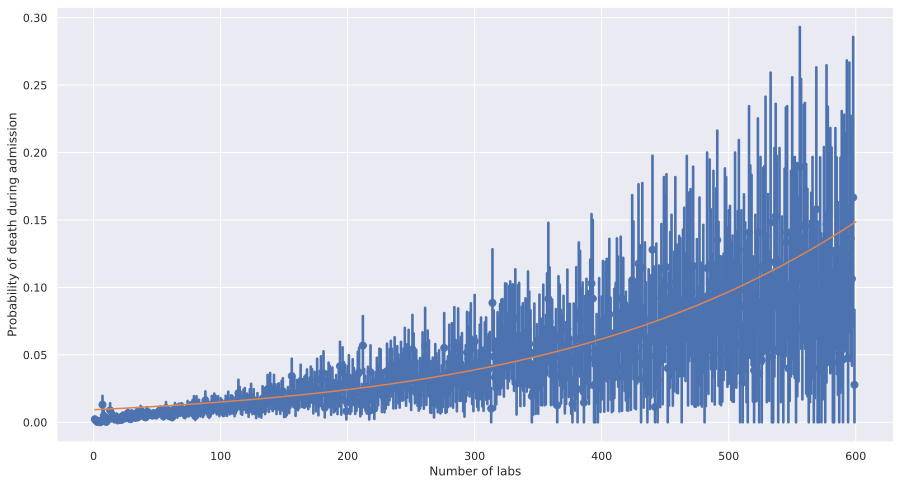

In [ ]:
sns.regplot(
    x='num_labs',
    y='died',
    data=scatter_df,
    fit_reg=False,
    x_bins=np.arange(1,
                     int(hist_df_n_labs.n_labs.max()) + 1))
plt.plot(line_df.number_of_labs,
         line_df.predicted_died_probs.apply(lambda x: x[0]['prob']))
plt.xlabel('Number of labs')
plt.ylabel('Probability of death during admission')

In [ ]:
def set_precision(df):
  df['precision'] = df.true_positives / (df.true_positives + df.false_positives)


def plot_precision_recall(df, label='Precision-Recall curve', how_many_null = 1):
    set_precision(df)
    # manually add the threshold = -∞ point
    df = df[df.true_positives != 0]
    recall = [0] + list(df.recall)
    precision = [1] + list(df.precision)
    # x=recall, y=precision line chart
    plt.plot(recall, precision, label=label)
    if how_many_null == 1:
        plt.plot(
        np.linspace(0, 1, 2), [df.precision.min()] * 2,
        label='null model',
        linestyle='--')
    plt.legend()
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.01, 1.01])
    plt.xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
    plt.ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')




def plot_roc(df, label='ROC curve', how_many_null = 1):
    tp_rate = [0] + list(df.recall)
    fp_rate = [1] + list(df.false_positive_rate)
    # x=fp_rate, y=tp_rate line chart
    plt.plot(fp_rate, tp_rate, label=label)
    if how_many_null == 1:
        plt.plot(
        np.linspace(0, 1, 2),
        label='null model',
        linestyle='--')
    plt.legend()
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.01, 1.01])
    plt.xlabel(r'True positive rate (=Recall) $\left(\frac{T_p}{T_p + F_n} \right)$')
    plt.ylabel(r'False positive rate $\left(\frac{F_p}{F_p + T_n} \right)$')

## Plotting ROC and precision-recall curves:

In [ ]:
%%bigquery q1_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}labs_mortality_models`)

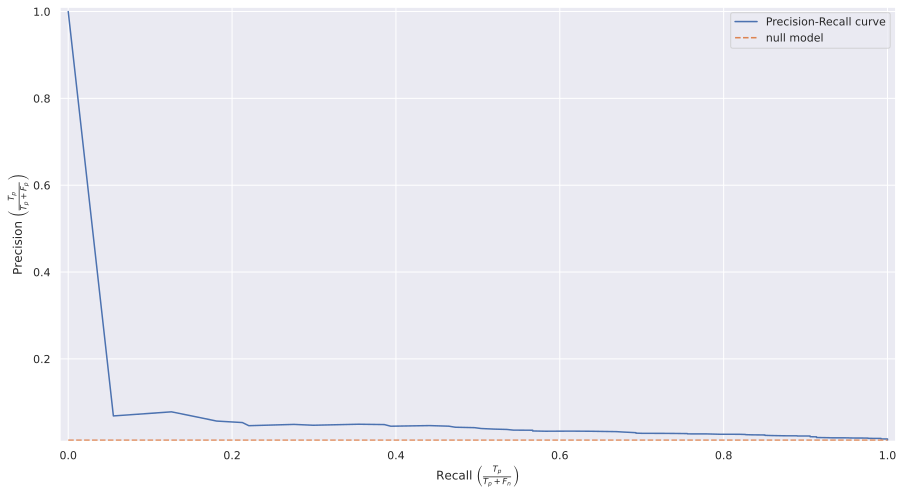

In [ ]:
plot_precision_recall(q1_roc)

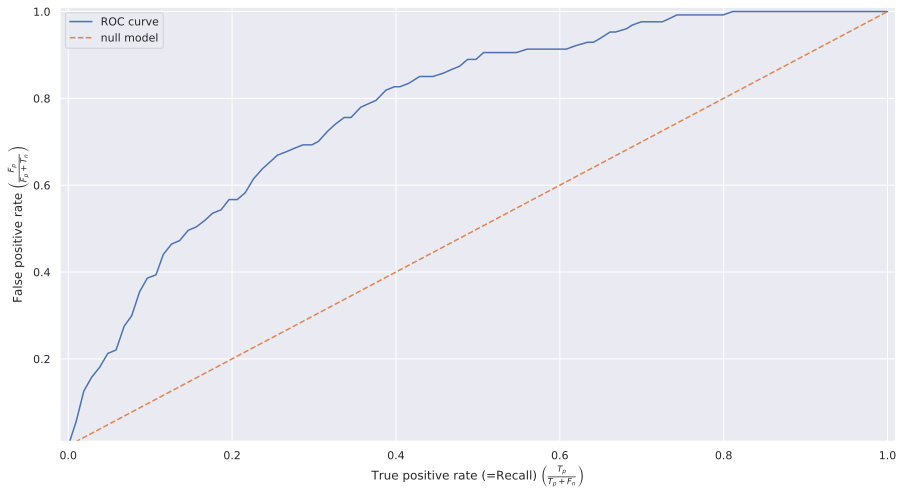

In [ ]:
plot_roc(q1_roc)

## AUC scores:

In [ ]:
from sklearn.metrics import auc
#bigquery isn't supply auc for precision-recall so I used sklearn for this task
eval_query = 'SELECT roc_auc FROM ML.EVALUATE(''MODEL `{ml_table_prefix}labs_mortality_models`)'.format(**sub_dict)
roc_auc = bq.query(eval_query).result().to_dataframe().iloc[0].values[0]

eval_query = 'SELECT recall, true_positives / (true_positives + false_positives) AS precision FROM ML.ROC_CURVE(''MODEL `{ml_table_prefix}labs_mortality_models`)'.format(**sub_dict)
precision_recall_df = bq.query(eval_query).result().to_dataframe()

print('Precision-Recall AUC=',auc(precision_recall_df.recall, precision_recall_df.precision))
print('Roc AUC=',roc_auc)

Precision-Recall AUC= 0.039889160516054206
Roc AUC= 0.7809180819180819


#2. Predict mortality during admission by number of labs, gender, age, admission 
type, admission location, insurance, marital status, and ethnicity:

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `{ml_table_prefix}lab_and_more_for_mortality`
OPTIONS(model_type='logistic_reg', l2_reg=2, input_label_cols=["died"])
AS
SELECT
  # MIMIC-IV sets all ages over 89 to 91 to avoid the possibility of
  # identification.
  gender,
  anchor_age AS age,
  num_labs,
  admission_type,
  admission_location,
  insurance,
  marital_status,
  ethnicity,
  died
FROM
  (SELECT
    COUNT(*) AS num_labs,
    MAX(HOSPITAL_EXPIRE_FLAG) as died,
    ANY_VALUE(ADMITTIME) as ADMITTIME,
    admission_type,
    admission_location,
    insurance,
    marital_status,
    ethnicity,
    SUBJECT_ID
  FROM
    `{admissions_table}` AS adm
    JOIN `{labevents_table}` AS lab
  USING (HADM_ID, SUBJECT_ID)
  GROUP BY HADM_ID, SUBJECT_ID,     
    admission_type,
    admission_location,
    insurance,
    marital_status,
    ethnicity
  )
  JOIN `{patients_table}` AS patients
  USING (SUBJECT_ID)

When we investigate the weights for this model, we see the weight associated
with the number of diagnoses is only slightly smaller now. This tells us that
some of the effect we saw in the univariate model was due to the confounding
influence of age, but most of it wasn't.

In [ ]:
%%bigquery
SELECT * FROM ML.WEIGHTS(MODEL `{ml_table_prefix}lab_and_more_for_mortality`)

,processed_input,weight,category_weights
0,gender,NaN,"[{'category': 'F', 'weight': -0.72436398962343..."
1,age,0.014383,[]
2,num_labs,0.001076,[]
3,admission_type,NaN,"[{'category': 'URGENT', 'weight': -0.500633357..."
4,admission_location,NaN,"[{'category': 'TRANSFER FROM HOSPITAL', 'weigh..."
5,insurance,NaN,"[{'category': 'Other', 'weight': -0.7924773540..."
6,marital_status,NaN,"[{'category': 'MARRIED', 'weight': -0.67547744..."
7,ethnicity,NaN,"[{'category': 'UNKNOWN', 'weight': 0.653108200..."
8,__INTERCEPT__,-1.425676,[]


## Plotting ROC and precision-recall curves:

In [ ]:
%%bigquery q2_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}lab_and_more_for_mortality`)

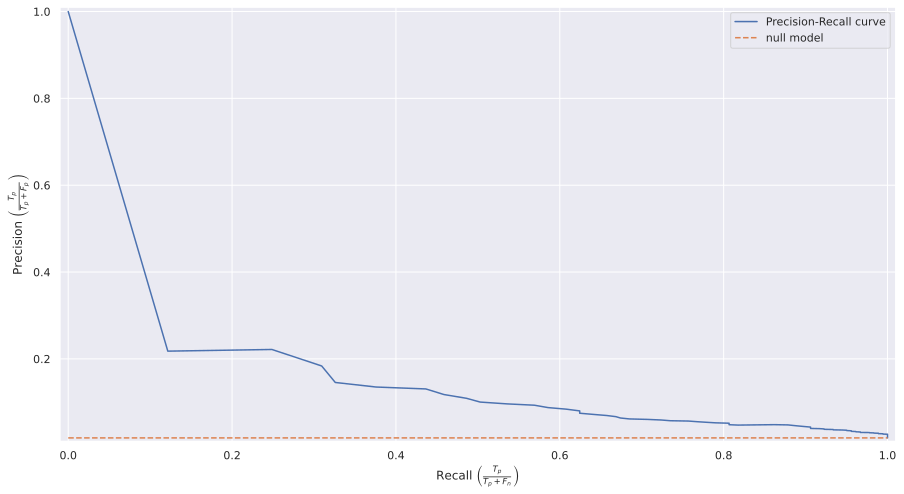

In [ ]:
plot_precision_recall(q2_roc)

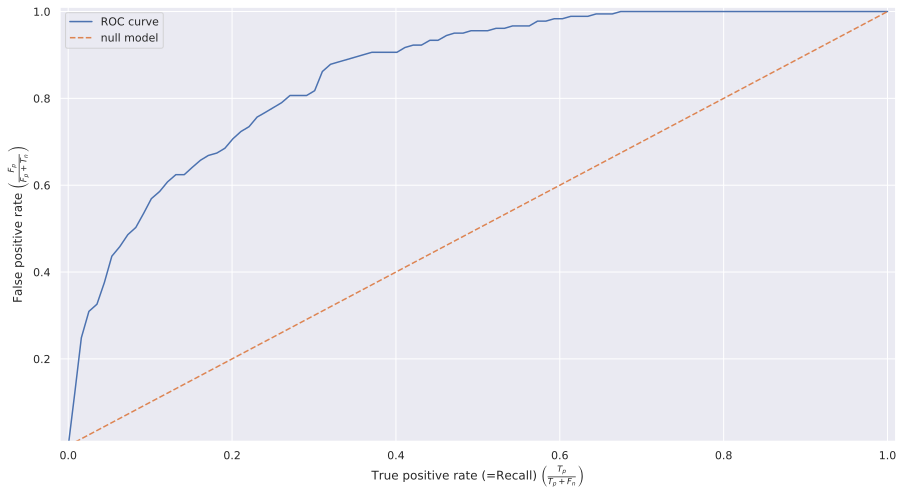

In [ ]:
plot_roc(q2_roc)

## AUC scores:

In [ ]:
eval_query = 'SELECT roc_auc FROM ML.EVALUATE(''MODEL `{ml_table_prefix}lab_and_more_for_mortality`)'.format(**sub_dict)
roc_auc = bq.query(eval_query).result().to_dataframe().iloc[0].values[0]

eval_query = 'SELECT recall, true_positives / (true_positives + false_positives) AS precision FROM ML.ROC_CURVE(''MODEL `{ml_table_prefix}lab_and_more_for_mortality`)'.format(**sub_dict)
precision_recall_df = bq.query(eval_query).result().to_dataframe()

print('Precision-Recall AUC=',auc(precision_recall_df.recall, precision_recall_df.precision))
print('Roc AUC=',roc_auc)



Precision-Recall AUC= 0.10908020106369541
Roc AUC= 0.8576113886113886


# 3. Predict mortality during admission by number of labs, gender, age, admission type, admission location, insurance, marital status, ethnicity and one hot encoding for m most common labs. Where m ∈ {8,16,32,64,128,256,512}.


We'll start by getting a list of the most frequent labs

In [ ]:
%%bigquery top_labs
WITH top_labs AS (
  SELECT COUNT(*) AS count, itemid FROM `{labevents_table}`
  GROUP BY itemid
)
SELECT top_labs.itemid, lab_lookup.label, top_labs.count FROM
top_labs JOIN
 `{d_labitems_table}` AS lab_lookup
USING (itemid)
ORDER BY count DESC LIMIT 512

In [ ]:
top_n_labs = (8, 16, 32, 64, 128, 256, 512)

In [ ]:
query_jobs = list()
for m in top_n_labs:
  # The expressions for creating the new columns for each input diagnosis
  labs_columns = list()
  for _, row in top_labs.iloc[:m].iterrows():
    labs_columns.append('MAX(IF(itemid = {0}, 1.0, 0.0))'
                             ' as `itemid_{0}`'.format(row.itemid))

  query = """
  CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_top_n_labs{m}`
  OPTIONS(model_type='logistic_reg', l1_reg=2, input_label_cols=["died"])
  AS
  WITH labs AS (
    SELECT
      HADM_ID,
      COUNT(*) AS num_lab,
      {lab_cols}
    FROM `{labevents_table}`
    WHERE itemid IS NOT NULL
    GROUP BY HADM_ID
  )
  SELECT
    anchor_age AS age,
    labs.* EXCEPT (HADM_ID),
    adm.HOSPITAL_EXPIRE_FLAG as died,
    adm.ADMISSION_TYPE as adm_type,
    adm.INSURANCE as insurance,
    patients.GENDER
  FROM
    `{admissions_table}` AS adm
    LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
    LEFT JOIN labs USING (HADM_ID)
  """.format(
      m=m, lab_cols=',\n    '.join(labs_columns), **sub_dict)
  # Run the query, and track its progress with query_jobs
  query_jobs.append(bq.query(query))

# Wait for all of the models to finish training
for j in query_jobs:
  j.exception()

## Plotting ROC and precision-recall curves:

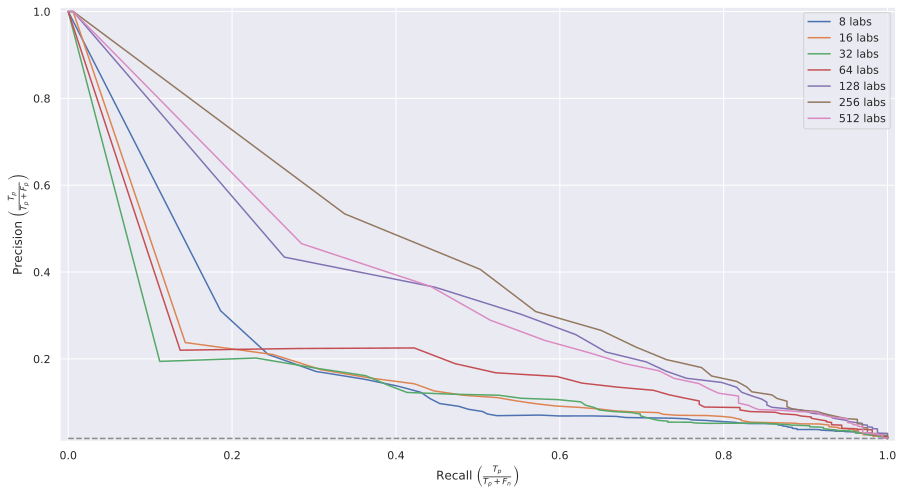

In [ ]:
for m in top_n_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  plot_precision_recall(df, label='{} labs'.format(m), how_many_null=0)
plt.plot(
        np.linspace(0, 1, 2), [df.precision.min()] * 2,
        label='null model',
        linestyle='--')

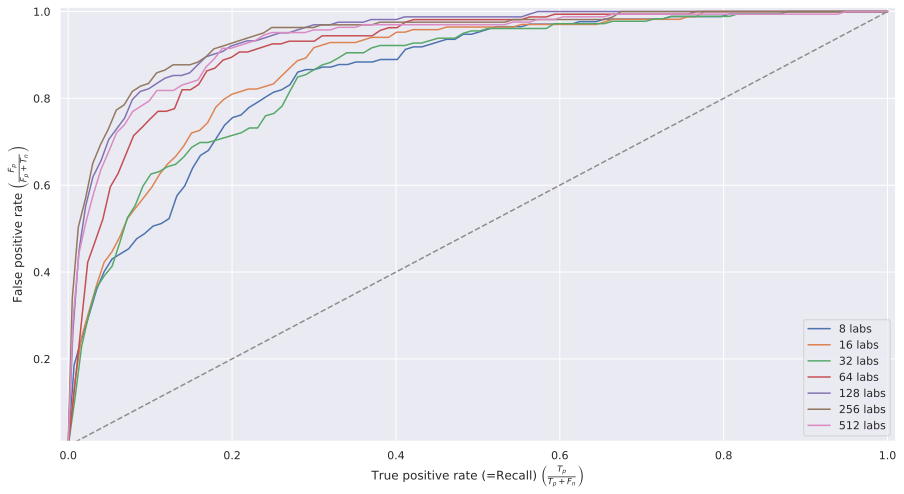

In [ ]:
for m in top_n_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  plot_roc(df, label='{} labs'.format(m), how_many_null=0)

plt.plot(
    np.linspace(0, 1, 2),
    label='null model',
    linestyle='--')

## AUC scores:

In [ ]:
ls_Precision_Recall_AUC, ls_Roc_AUC = [], []
for m in top_n_labs:
    eval_query = 'SELECT roc_auc FROM ML.EVALUATE(''MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'.format(m, **sub_dict)
    roc_auc = bq.query(eval_query).result().to_dataframe().iloc[0].values[0]

    eval_query = 'SELECT recall, true_positives / (true_positives + false_positives) AS precision FROM ML.ROC_CURVE(''MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'.format(m, **sub_dict)
    precision_recall_df = bq.query(eval_query).result().to_dataframe()

     
    ls_Precision_Recall_AUC.append(auc(precision_recall_df.recall, precision_recall_df.precision))
    ls_Roc_AUC.append(roc_auc)



In [ ]:
d = {'Labs amount':top_n_labs, 'Precision Recall AUC': ls_Precision_Recall_AUC, 'Roc AUC': ls_Roc_AUC}
pd.DataFrame(data=d)

,Labs amount,Precision Recall AUC,Roc AUC
0,8,0.108839,0.854875
1,16,0.182606,0.878680
2,32,0.109594,0.860951
3,64,0.147933,0.916856
4,128,0.362187,0.942255
5,256,0.427361,0.943973
6,512,0.365733,0.930682


#4. Choose the optimal m and add to that model the most common 256 diagnoses (transformed to one hot encoding).

##It's important to say that we have unbalanced data and the precision-recall curve should be a more significant consideration than the roc curve.
###As we can see, The optimal m here is m=256 (At the plot The precision is the highest almost for every recall point, except the end when Recall>0.9) Also the AUC scores imply the same <br/>
So now I will merge the 256 common labs with the diagnoses 

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `{ml_table_prefix}lab_and_more_for_mortality`
OPTIONS(model_type='logistic_reg', l2_reg=2, input_label_cols=["died"])
AS
SELECT
  # MIMIC-IV sets all ages over 89 to 91 to avoid the possibility of
  # identification.
  gender,
  anchor_age AS age,
  num_labs,
  admission_type,
  admission_location,
  insurance,
  marital_status,
  ethnicity,
  died
FROM
  (SELECT
    COUNT(*) AS num_labs,
    MAX(HOSPITAL_EXPIRE_FLAG) as died,
    ANY_VALUE(ADMITTIME) as ADMITTIME,
    admission_type,
    admission_location,
    insurance,
    marital_status,
    ethnicity,
    SUBJECT_ID
  FROM
    `{admissions_table}` AS adm
    JOIN `{labevents_table}` AS lab
  USING (HADM_ID, SUBJECT_ID)
  GROUP BY HADM_ID, SUBJECT_ID,     
    admission_type,
    admission_location,
    insurance,
    marital_status,
    ethnicity
  )
  JOIN `{patients_table}` AS patients
  USING (SUBJECT_ID)

In [ ]:
%%bigquery top_diagnoses
WITH top_diag AS (
  SELECT COUNT(*) AS count, icd_code, icd_version FROM `{diagnoses_icd_table}`
  GROUP BY icd_code, icd_version
)
SELECT top_diag.icd_code, top_diag.icd_version,icd_lookup.long_title, top_diag.count FROM
top_diag JOIN
 `{d_icd_diagnoses_table}` AS icd_lookup
USING (icd_code, icd_version)
ORDER BY count DESC LIMIT 256

In [ ]:
top_diagnoses

,icd_code,icd_version,long_title,count
0,4019,9,Unspecified essential hypertension,104080
1,2724,9,Other and unspecified hyperlipidemia,68215
2,I10,10,Essential (primary) hypertension,54696
3,E785,10,"Hyperlipidemia, unspecified",51097
4,53081,9,Esophageal reflux,49593
...,...,...,...,...
251,7850,9,"Tachycardia, unspecified",3736
252,7907,9,Bacteremia,3732
253,I739,10,"Peripheral vascular disease, unspecified",3725
254,5723,9,Portal hypertension,3701


In [ ]:
# The expressions for creating the new columns for labs
labs_columns = list()
for _, row in top_labs.iloc[:256].iterrows():
    labs_columns.append('MAX(IF(itemid = {0}, 1.0, 0.0))'
                             ' as `itemid_{0}`'.format(row.itemid))

# The expressions for creating the new columns for diagnosis
diagnosis_columns = list()
for _, row in top_diagnoses.iloc[:256].iterrows():
    diagnosis_columns.append('MAX(IF(icd_code = "{0}" AND icd_version = {1}, 1.0, 0.0))'
                            ' as `icd{1}_{0}`'.format(row.icd_code, row.icd_version))

query = """
CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag`
OPTIONS(model_type='logistic_reg', l1_reg=2, input_label_cols=["died"])
AS
WITH labs AS (
SELECT
    HADM_ID,
    COUNT(*) AS num_lab,
    {lab_cols}
FROM `{labevents_table}`
WHERE itemid IS NOT NULL
GROUP BY HADM_ID
), diagnoses AS (
SELECT
    HADM_ID,
    COUNT(*) AS num_diag,
    {diag_cols}
FROM `{diagnoses_icd_table}`
WHERE icd_code IS NOT NULL
GROUP BY HADM_ID
)

SELECT
diagnoses.* EXCEPT (HADM_ID),
anchor_age AS age,
labs.* EXCEPT (HADM_ID),
adm.HOSPITAL_EXPIRE_FLAG as died,
adm.ADMISSION_TYPE as adm_type,
adm.INSURANCE as insurance,
patients.GENDER
FROM
`{admissions_table}` AS adm
LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
LEFT JOIN labs USING (HADM_ID)
LEFT JOIN diagnoses USING (HADM_ID)
""".format(
    lab_cols=',\n    '.join(labs_columns), diag_cols=',\n    '.join(diagnosis_columns), **sub_dict)

# # Run the query:
j = bq.query(query)
j.exception()

## Plotting ROC and precision-recall curves:

In [ ]:
%%bigquery q4_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag`)

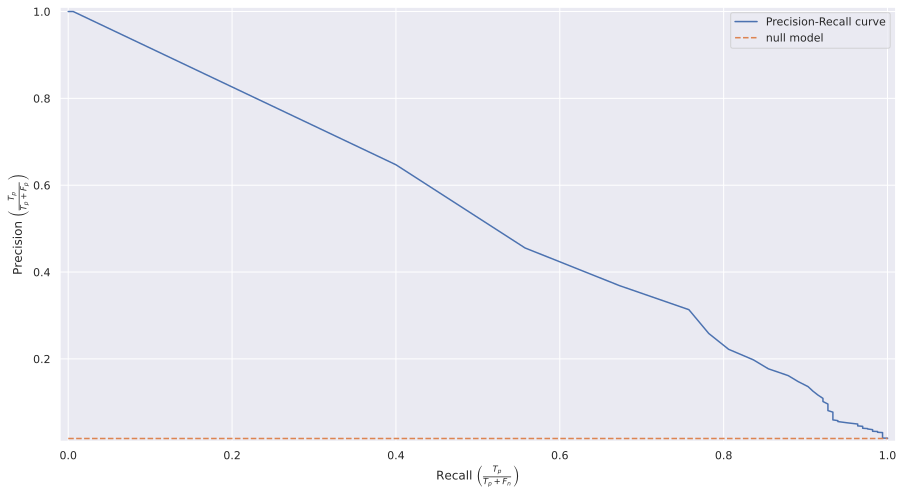

In [ ]:
plot_precision_recall(q4_roc)

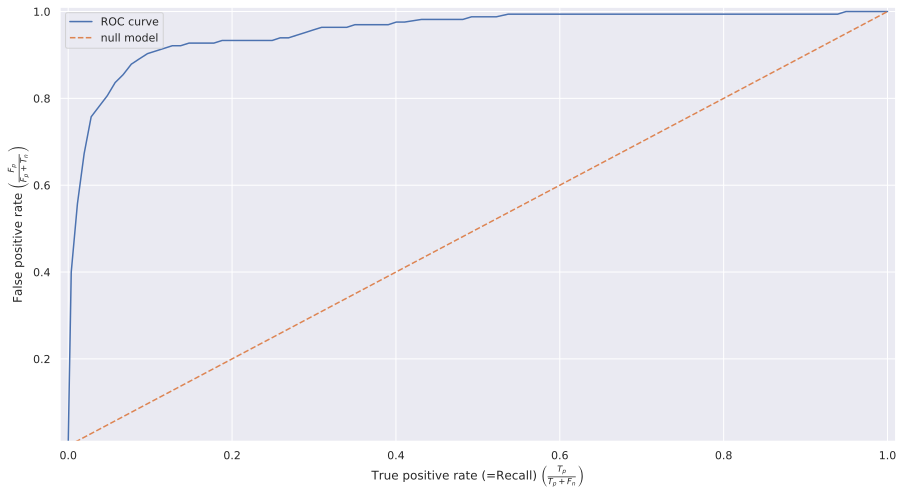

In [ ]:
plot_roc(q4_roc)

## AUC scores:

In [ ]:
eval_query = 'SELECT roc_auc FROM ML.EVALUATE(''MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag`)'.format(**sub_dict)
roc_auc = bq.query(eval_query).result().to_dataframe().iloc[0].values[0]

eval_query = 'SELECT recall, true_positives / (true_positives + false_positives) AS precision FROM ML.ROC_CURVE(''MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag`)'.format(**sub_dict)
precision_recall_df = bq.query(eval_query).result().to_dataframe()

In [ ]:
print('Precision-recall auc=',auc(precision_recall_df.recall, precision_recall_df.precision))
print('Roc auc=',roc_auc)

Precision-recall auc= 0.5240544737580934
Roc auc= 0.9546033966033967


#5. Bonus: Same features as previous one, but limit the data that was collected in the first 24 hours of admission.

##For this task I'm using the table 'icustays' in order to check the lab and diagnosis happend no more than 24 hours after the intime attribute of the 'icustays'

In [56]:
# The expressions for creating the new columns for labs
labs_columns = list()
for _, row in top_labs.iloc[:256].iterrows():
    labs_columns.append('MAX(IF(itemid = {0}, 1.0, 0.0))'
                             ' as `itemid_{0}`'.format(row.itemid))

# The expressions for creating the new columns for diagnosis
diagnosis_columns = list()
for _, row in top_diagnoses.iloc[:256].iterrows():
    diagnosis_columns.append('MAX(IF(icd_code = "{0}" AND icd_version = {1}, 1.0, 0.0))'
                            ' as `icd{1}_{0}`'.format(row.icd_code, row.icd_version))

query = """
CREATE OR REPLACE MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag_firs_24_hours`
OPTIONS(model_type='logistic_reg', l1_reg=2, input_label_cols=["died"])
AS
WITH labs AS (
SELECT
    HADM_ID,
    COUNT(*) AS num_lab,
    {lab_cols}
FROM `{labevents_table}` lb INNER JOIN `{icustays_table}` st USING (hadm_id)
WHERE itemid IS NOT NULL and lb.charttime <= DATETIME_ADD(st.intime, INTERVAL '24' HOUR)
GROUP BY HADM_ID
), diagnoses AS (
SELECT
    HADM_ID,
    COUNT(*) AS num_diag,
    {diag_cols}
FROM `{diagnoses_icd_table}` dg INNER JOIN `{icustays_table}` st USING (hadm_id)
WHERE icd_code IS NOT NULL
GROUP BY HADM_ID
)

SELECT
diagnoses.* EXCEPT (HADM_ID),
anchor_age AS age,
labs.* EXCEPT (HADM_ID),
adm.HOSPITAL_EXPIRE_FLAG as died,
adm.ADMISSION_TYPE as adm_type,
adm.INSURANCE as insurance,
patients.GENDER
FROM
`{admissions_table}` AS adm
LEFT JOIN `{patients_table}` AS patients USING (SUBJECT_ID)
LEFT JOIN labs USING (HADM_ID)
LEFT JOIN diagnoses USING (HADM_ID)
""".format(
    lab_cols=',\n    '.join(labs_columns), diag_cols=',\n    '.join(diagnosis_columns), **sub_dict)

# # Run the query:
j = bq.query(query)
j.exception()

## Plotting ROC and precision-recall curves:

In [59]:
%%bigquery q5_roc
SELECT * FROM ML.ROC_CURVE(MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag_firs_24_hours`)

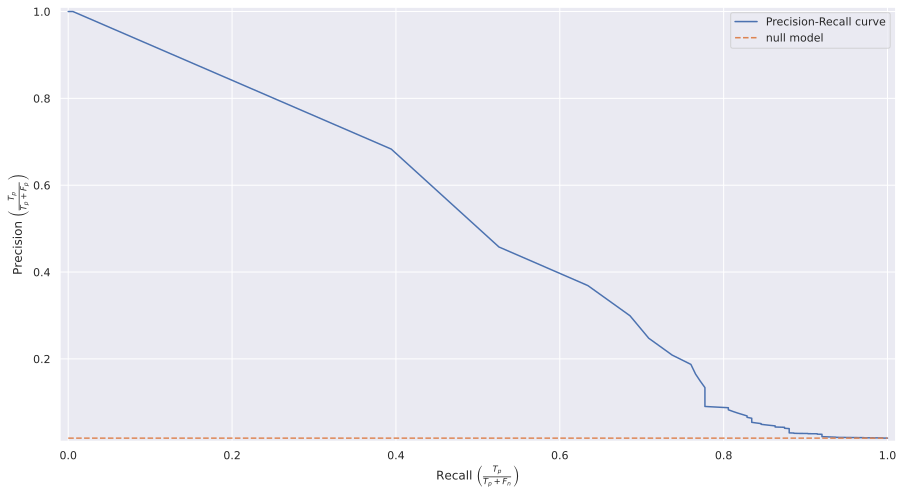

In [60]:
plot_precision_recall(q5_roc)

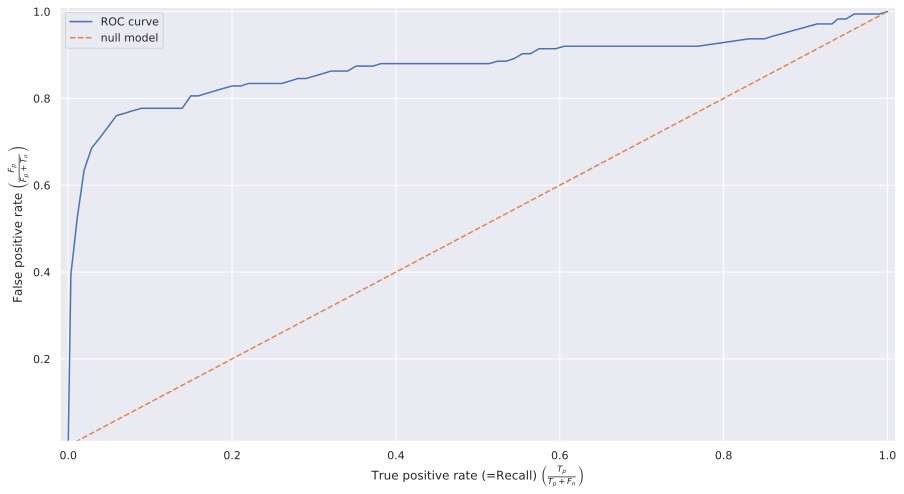

In [61]:
plot_roc(q5_roc)

## AUC scores:

In [62]:
eval_query = 'SELECT roc_auc FROM ML.EVALUATE(''MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag_firs_24_hours`)'.format(**sub_dict)
roc_auc = bq.query(eval_query).result().to_dataframe().iloc[0].values[0]

eval_query = 'SELECT recall, true_positives / (true_positives + false_positives) AS precision FROM ML.ROC_CURVE(''MODEL `{ml_table_prefix}predict_mortality_top_256_labs_top_256_diag_firs_24_hours`)'.format(**sub_dict)
precision_recall_df = bq.query(eval_query).result().to_dataframe()

In [63]:
print('Precision-recall auc=',auc(precision_recall_df.recall, precision_recall_df.precision))
print('Roc auc=',roc_auc)

Precision-recall auc= 0.4934301660546161
Roc auc= 0.8726073926073926


Here I got worst performances than previous task

#Part 2 - Discussion


###The differences between the models:

Plot Precision-recall and roc curves for all the models:

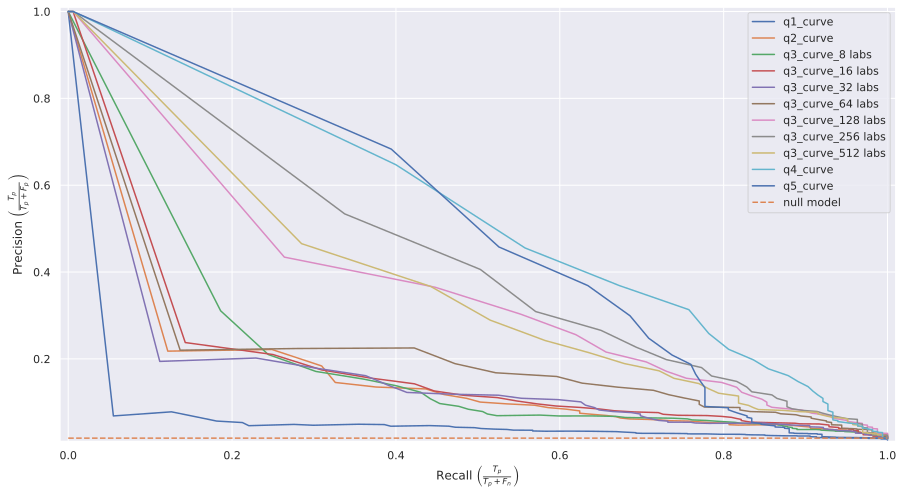

In [64]:
plot_precision_recall(q1_roc, label = 'q1_curve', how_many_null=0)
plot_precision_recall(q2_roc, label = 'q2_curve', how_many_null=0)
for m in top_n_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  plot_precision_recall(df, label='q3_curve_{} labs'.format(m), how_many_null=0)
plot_precision_recall(q4_roc, label = 'q4_curve', how_many_null=0)
plot_precision_recall(q5_roc, label = 'q5_curve')

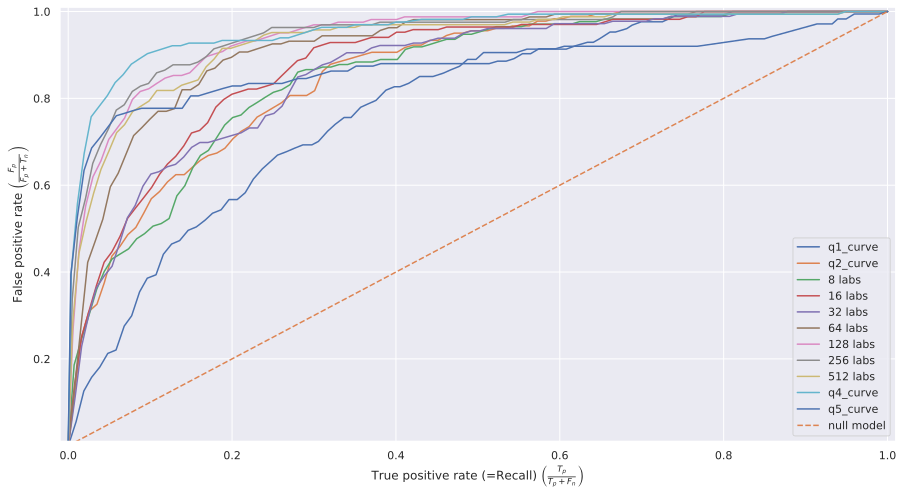

In [65]:
plot_roc(q1_roc, label = 'q1_curve', how_many_null=0)
plot_roc(q2_roc, label = 'q2_curve', how_many_null=0)
for m in top_n_labs:
  df = bq.query('SELECT * FROM ML.ROC_CURVE('
                'MODEL `{ml_table_prefix}predict_mortality_top_n_labs{}`)'
                .format(m, **sub_dict)).result().to_dataframe()
  plot_roc(df, label='{} labs'.format(m), how_many_null=0)
plot_roc(q4_roc, label = 'q4_curve', how_many_null=0)
plot_roc(q5_roc, label = 'q5_curve')

##First of all, It's important to say that the data is imbalanced so the precision- recall curve is more reliable in terms of which model is performe better
###As we can see, the model in task 4 gives us the best performance. (In task 5(Bonus) - It seems a bit overfit when looking at the curve)
####Also we can see that escalation in model complexity (and choosing the features more carefuly) in this case lead to better results when we have enough data. (It can be seen in the diffrence between the models in task 2 and 3 - when m is lower than 64 labs, the model of task 2 with all the data about labs is better. But when the number of labs passes 64, clearly the most m ferquent is better)

#Do you think the ICU can use your model and take advantage of it? Explain your answer and describe why it might be useful or useless.

#Answer:
It might be both useful and useless, I will explain - 
First of all, The model of task 4 get pretty nice performance, So the ICU can use it in order to know who might be in higher risk and pay (extra) attention for this kind of people.
But I have to admit that I'm not supplying here insights about predict mortality for any admision, And this is because I summarized the quantity of labs and treated every lab the same, But in the clinic world we have a lot of kind of labs with relating to diseases with very different risk levels, So this summarizing will be way better if it will be weighted, when "more serious" labs will be weight different than "regular" labs, because they imply very different diseases.
<br/><br/>
Another improvement with rapid implementation that can make this model much more reliable and useful is creating an explanation for predictions using SHAP or any other XAI model that will give an intuitive explanation to the medical staff of what the model predicts mortality from, it can be effective because the model's performance is really not bad, but It is necessary to have something beyond here that will help to draw conclusions and trust the model more